<a href="https://colab.research.google.com/github/derek-byte/Melanoma_Deep_Learning/blob/main/MELANOMA_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [2]:
train_dir='/content/drive/MyDrive/Melanoma_Dataset/train'
labels = ['Melanoma', 'NotMelanoma']
print ("class :", labels[0], ",", labels[1]) 

class : Melanoma , NotMelanoma


In [3]:
handle_base = "mobilenet_v2"
FV_SIZE = 1280
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (224, 224)
# BATCH_SIZE = 16 
BATCH_SIZE = 32

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 7290 images belonging to 2 classes.
Found 3123 images belonging to 2 classes.


In [5]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
___________________

In [6]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [8]:
EPOCHS=25
# EPOCHS=25
# steps = 10
steps = train_generator.samples//train_generator.batch_size

history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        # steps_per_epoch = 10,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/25
227/227 [==============================] - 1602s 7s/step - loss: 0.2234 - accuracy: 0.9194 - val_loss: 0.0790 - val_accuracy: 0.9765
Epoch 2/25
227/227 [==============================] - 540s 2s/step - loss: 0.1725 - accuracy: 0.9374 - val_loss: 0.1268 - val_accuracy: 0.9507
Epoch 3/25
227/227 [==============================] - 438s 2s/step - loss: 0.1575 - accuracy: 0.9425 - val_loss: 0.0304 - val_accuracy: 0.9965
Epoch 4/25
227/227 [==============================] - 436s 2s/step - loss: 0.1517 - accuracy: 0.9446 - val_loss: 0.0511 - val_accuracy: 0.9923
Epoch 5/25
227/227 [==============================] - 438s 2s/step - loss: 0.1452 - accuracy: 0.9456 - val_loss: 0.0563 - val_accuracy: 0.9932
Epoch 6/25
227/227 [==============================] - 446s 2s/step - loss: 0.1366 - accuracy: 0.9496 - val_loss: 0.0432 - val_accuracy: 0.9955
Epoch 7/25
227/227 [==============================] - 442s 2s/step - loss: 0.1407 - accuracy: 0.9498 - val_loss: 0.0697 - val_accuracy: 0.983

Checking Performance

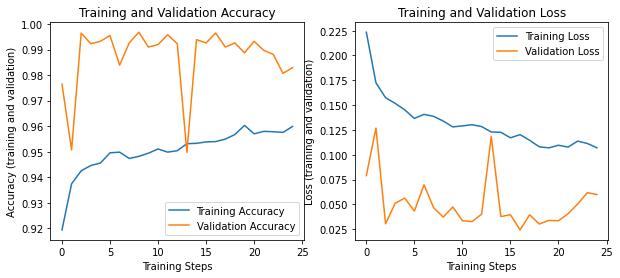

In [9]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

Test At Random

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0025250.jpg
class: NotMelanoma, Confidence: 0.946387


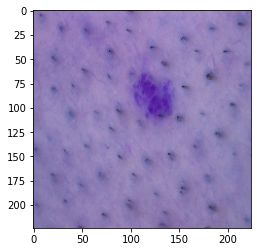

<Figure size 432x288 with 0 Axes>

SOURCE: class: Melanoma, file: Melanoma/AUG_0_1192.jpeg
class: Melanoma, Confidence: 1.000000


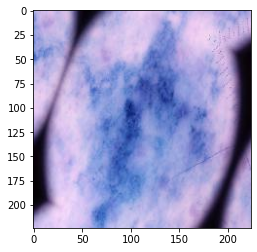

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0024874.jpg
class: NotMelanoma, Confidence: 0.990830


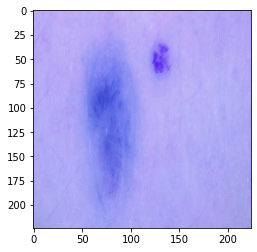

<Figure size 432x288 with 0 Axes>

SOURCE: class: Melanoma, file: Melanoma/AUG_0_1473.jpeg
class: Melanoma, Confidence: 0.999720


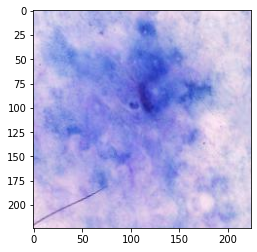

<Figure size 432x288 with 0 Axes>

SOURCE: class: Melanoma, file: Melanoma/AUG_0_293.jpeg
class: Melanoma, Confidence: 0.995065


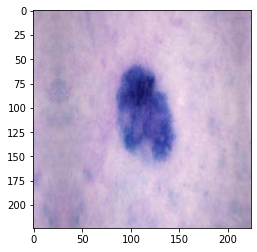

<Figure size 432x288 with 0 Axes>

SOURCE: class: Melanoma, file: Melanoma/AUG_0_2401.jpeg
class: Melanoma, Confidence: 0.999988


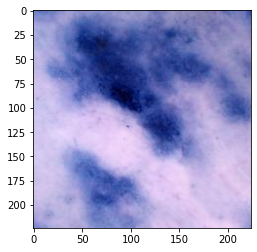

<Figure size 432x288 with 0 Axes>

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0027085.jpg
class: NotMelanoma, Confidence: 0.990702


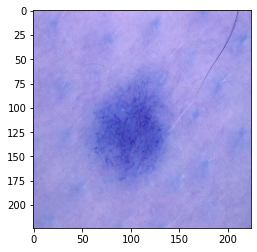

<Figure size 432x288 with 0 Axes>

SOURCE: class: Melanoma, file: Melanoma/AUG_0_4018.jpeg
class: Melanoma, Confidence: 0.997399


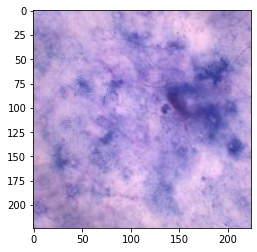

<Figure size 432x288 with 0 Axes>

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0025935.jpg
class: NotMelanoma, Confidence: 0.992293


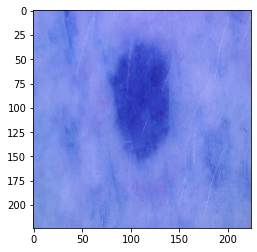

<Figure size 432x288 with 0 Axes>

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0025076.jpg
class: NotMelanoma, Confidence: 0.998477


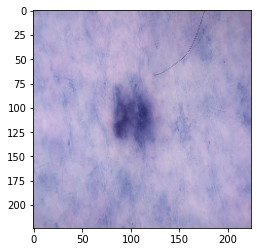

<Figure size 432x288 with 0 Axes>

SOURCE: class: Melanoma, file: Melanoma/AUG_0_1725.jpeg
class: Melanoma, Confidence: 0.976759


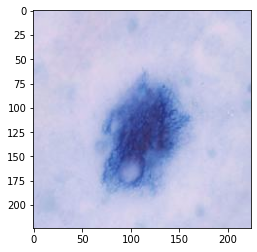

<Figure size 432x288 with 0 Axes>

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0024946.jpg
class: NotMelanoma, Confidence: 0.932195


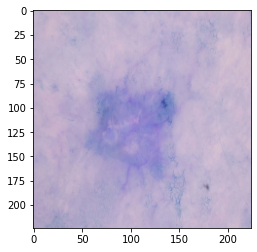

<Figure size 432x288 with 0 Axes>

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0027028.jpg
class: NotMelanoma, Confidence: 0.996089


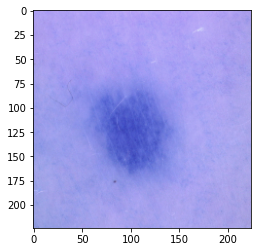

<Figure size 432x288 with 0 Axes>

SOURCE: class: Melanoma, file: Melanoma/AUG_0_2338.jpeg
class: Melanoma, Confidence: 1.000000


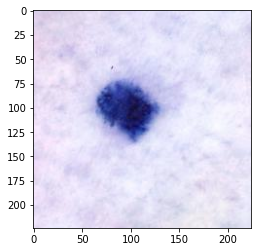

<Figure size 432x288 with 0 Axes>

SOURCE: class: Melanoma, file: Melanoma/AUG_0_259.jpeg
class: Melanoma, Confidence: 1.000000


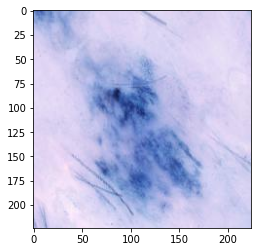

<Figure size 432x288 with 0 Axes>

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0027199.jpg
class: NotMelanoma, Confidence: 0.999850


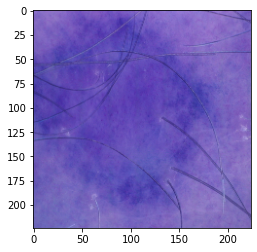

<Figure size 432x288 with 0 Axes>

In [10]:
import random
import cv2
import numpy as np 
import matplotlib.pylab as plt

def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img
def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)
for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    print("class: %s, Confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

Confusion Matrix

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
report = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(report)

evaluates = model.evaluate(validation_generator)
print(evaluates)

Classification Report
              precision    recall  f1-score   support

    Melanoma       0.97      1.00      0.98      1521
 NotMelanoma       1.00      0.97      0.98      1602

    accuracy                           0.98      3123
   macro avg       0.98      0.98      0.98      3123
weighted avg       0.98      0.98      0.98      3123

98/98 [==============================] - 139s 1s/step - loss: 0.0606 - accuracy: 0.9843
[0.06062297895550728, 0.98430997133255]


Confusion Matrix


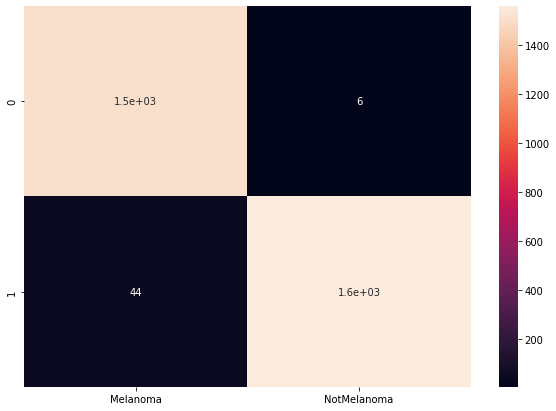

In [12]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
data_frame = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(data_frame, annot=True)

Export as Saved Model and Convert to TFLite

In [13]:
import time
t = time.time()
export_path = "/content/drive/MyDrive/Melanoma_Batch_32".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Melanoma_Batch_32/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Melanoma_Batch_32/assets


'/content/drive/MyDrive/Melanoma_Batch_32'

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
path = "/content/drive/MyDrive/Melanoma_Models_Good_Copy"
reloaded = tf.keras.models.load_model(path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {labels[class_idx]: probabilities[class_idx]}

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# # convert the model to TFLite
# !mkdir "tflite_models"
# TFLITE_MODEL = "tflite_models/model.tflite"
# # Get the concrete function from the Keras model.
# run_model = tf.function(lambda x : reloaded(x))
# # Save the concrete function.
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
# )
# # Convert the model to standard TensorFlow Lite model
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
# converted_tflite_model = converter.convert()
# open(TFLITE_MODEL, "wb").write(converted_tflite_model)

Streamlit

In [ ]:
!pip install streamlit

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken 26myWhdKL3FJvSiQfVOLduesolf_3iGZpQGynAH14orGSyv9z

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
%%writefile app.py

import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobile 
import tensorflow_hub as hub
import matplotlib.pylab as plt
import os
import random

labels = ['Melanoma', 'NotMelanoma']

from PIL import Image, ImageOps
@st.cache
def load_image(image_file):
  img = Image.open(image_file)
  return img

def upload(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img

st.title("Melanoma Detection")

path = "/content/drive/MyDrive/Melanoma_Models_Good_Copy"
# path = "/content/drive/MyDrive/Melanoma_Steps_455"
reloaded = tf.keras.models.load_model(path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {labels[class_idx]: probabilities[class_idx]}

uploaded_file = st.file_uploader("Choose an image file", type=["png", "jpeg", "jpg", "svg"])

if uploaded_file is not None:
  # Convert the file to an opencv image
  file_bytes = np.asarray(bytearray(uploaded_file.read()),dtype=np.uint8)
  opencv_image = cv2.imdecode(file_bytes, 1)
  opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
  resized = cv2.resize(opencv_image, (224,224))
  st.image(load_image(uploaded_file), width=224)

  # Saving File
  complete_path = os.path.join("/content/Melanoma_Images", uploaded_file.name)

  # CREATE THIS FILE SOURCE EVERYTIME ON GOOGLE COLAB
  with open(complete_path, "wb") as f:
    f.write(uploaded_file.getbuffer())
  st.success("File Saved")

  # Download to google drive?

  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)
  
  validation_generator = train_datagen.flow_from_directory(
    "/content/Melanoma_Images", 
    color_mode="rgb", 
    shuffle=False, 
    seed=None,
    class_mode="categorical",
    subset="validation",
    target_size=(224,224),
    batch_size=1)

  img = upload(complete_path)
  prediction = predict_reload(img)
  st.success("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))

Overwriting app.py


In [ ]:
from pyngrok import ngrok
# Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(port='80')
print(public_url)
!streamlit run --server.port 80 app.py >/dev/null


NgrokTunnel: "http://0803-35-245-134-84.ngrok.io" -> "http://localhost:80"
2022-04-22 01:26:28.018 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
2022-04-22 01:26:36.320747: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-22 01:26:36.332 Using /tmp/tfhub_modules to cache modules.


In [ ]:
!pgrep streamlit